# Air Transportation Ocurrences
## Exploring Relationships Between Aviation Incidents and External Factors

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../scripts")

In [4]:
from data_loader import load_data_from_csv, load_data_from_temp, load_data_from_filtered
from common.export_csv import exportDataVersion
import pandas as pd
import numpy as np

In [5]:
#Load occurrences data
occurrences_df = load_data_from_csv('fullData_V2.csv')
#Data length
print(f"# of rows 'fullData_V2.csv': {len(occurrences_df)}")

# of rows 'fullData_V2.csv': 47781


In [6]:
#Load dollar exchange
dollar_df = load_data_from_filtered("dollar_exchange_filtered.csv")

In [7]:
#Load birth rate
births_df = load_data_from_filtered("birth_rate_filtered.csv")

In [8]:
#Load passenger traffic 
passenger_traffic = load_data_from_filtered("passenger_traffic_filtered.csv")

In [9]:
# Filter the DataFrame and create a copy to avoid SettingWithCopyWarning
filtered_df = passenger_traffic[
    (passenger_traffic['GEO'] == 'Total of eight largest airports, Canada') &
    (passenger_traffic['Screened traffic'] == 'Total screened traffic')
].copy()

# Convert REF_DATE to datetime and extract year and month
filtered_df['REF_DATE'] = pd.to_datetime(filtered_df['REF_DATE'], format='%b-%y')
filtered_df['YearMonth'] = filtered_df['REF_DATE'].dt.to_period('M')

# Group by YearMonth and calculate the sum of VALUE
summed_df = filtered_df.groupby('YearMonth')['VALUE'].sum().reset_index()

# Rename columns for clarity
summed_df.rename(columns={'VALUE': 'Total_Screened_Traffic'}, inplace=True)

print(summed_df)


   YearMonth  Total_Screened_Traffic
0    2019-01                 4412813
1    2019-02                 4161705
2    2019-03                 4698908
3    2019-04                 4432901
4    2019-05                 4564129
..       ...                     ...
64   2024-05                 4714460
65   2024-06                 5049935
66   2024-07                 5729343
67   2024-08                 5881612
68   2024-09                 4903309

[69 rows x 2 columns]


In [10]:
selected_provinces = [
    'ALBERTA', 'BRITISH COLUMBIA', 'MANITOBA', 'NEW BRUNSWICK',
    'NEWFOUNDLAND AND LABRADOR', 'NORTHWEST TERRITORIES',
    'NOVA SCOTIA', 'ONTARIO', 'QUEBEC', 'SASKATCHEWAN', 'YUKON'
]
occurrences_df = occurrences_df[occurrences_df['ProvinceID_DisplayEng'].str.upper().isin(selected_provinces)].copy()

# Reset the index of the filtered DataFrame (optional)
occurrences_df.reset_index(drop=True, inplace=True)

## Creating a file with number of occurrences, births and dolar exchange monthly

In [12]:
# Creating new column to store year and month in occurrences_df
occurrences_df['OccDate'] = pd.to_datetime(occurrences_df['OccDate'])
occurrences_df['YearMonth'] = occurrences_df['OccDate'].dt.to_period('M')

# Counting the number of occurrences per year-month
occurrences_count = occurrences_df.groupby('YearMonth').size().reset_index(name='occurrences')

# Preparing dollar exchange rate data
dollar_df = dollar_df.melt(var_name="YearMonth", value_name="dollar_exchange")
dollar_df['YearMonth'] = pd.to_datetime(dollar_df['YearMonth'], format='%b-%y').dt.to_period('M')

# Preparing birth rate data
births_df = births_df.melt(id_vars="Unnamed: 0", var_name="Year", value_name="births")
births_df.rename(columns={'Unnamed: 0': 'Month'}, inplace=True)
births_df['YearMonth'] = pd.to_datetime(births_df['Year'] + '-' + births_df['Month'], format='%Y-%B').dt.to_period('M')

# Preparing passenger traffic data
filtered_df = passenger_traffic[
    (passenger_traffic['GEO'] == 'Total of eight largest airports, Canada') &
    (passenger_traffic['Screened traffic'] == 'Total screened traffic')
].copy()

filtered_df['REF_DATE'] = pd.to_datetime(filtered_df['REF_DATE'], format='%b-%y')
filtered_df['YearMonth'] = filtered_df['REF_DATE'].dt.to_period('M')

# Grouping passenger traffic by YearMonth and summing up the values
passenger_traffic_sum = filtered_df.groupby('YearMonth')['VALUE'].sum().reset_index()
passenger_traffic_sum.rename(columns={'VALUE': 'passenger_traffic'}, inplace=True)

# Merging all data into a single DataFrame
merged_df = pd.merge(occurrences_count, dollar_df, on="YearMonth", how="outer")
merged_df = pd.merge(merged_df, births_df[['YearMonth', 'births']], on="YearMonth", how="outer")
final_df = pd.merge(merged_df, passenger_traffic_sum, on="YearMonth", how="outer")

# Sorting by YearMonth and resetting the index
final_df['YearMonth'] = final_df['YearMonth'].astype(str)  # Converting to string yyyy-MM format
final_df.sort_values(by='YearMonth', inplace=True)
final_df.reset_index(drop=True, inplace=True)

# Filtering the DataFrame to include only data between 1995-01 and 2023-12
final_df['YearMonth'] = pd.to_datetime(final_df['YearMonth']).dt.to_period('M')
start_date = pd.Period('1995-01', freq='M')
end_date = pd.Period('2023-12', freq='M')

final_df_filtered = final_df[(final_df['YearMonth'] >= start_date) & (final_df['YearMonth'] <= end_date)].copy()
final_df_filtered.reset_index(drop=True, inplace=True)

# Converting YearMonth back to string format
final_df_filtered.loc[:, 'YearMonth'] = final_df_filtered['YearMonth'].astype(str)

In [13]:
#Saving the file in V4
exportDataVersion(final_df_filtered, 3)

Version not allowed


In [14]:
df = final_df_filtered.copy()

### Correlation with birth date 

occurrences    0
births         0
dtype: int64
Correlation between occurrences and births: 0.2498


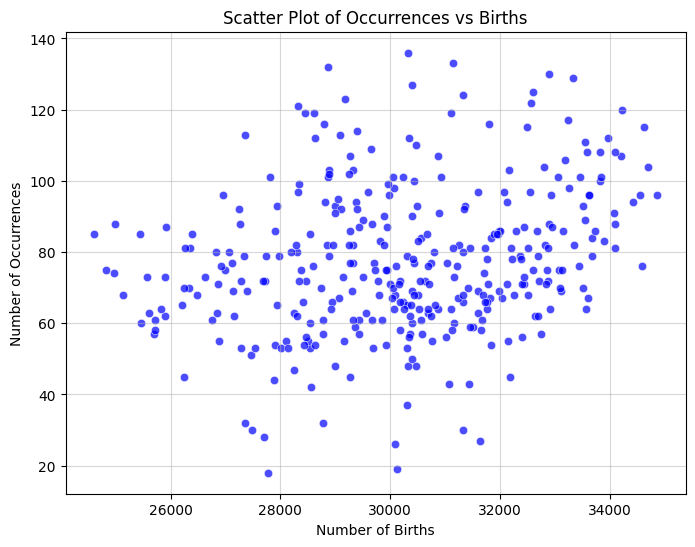

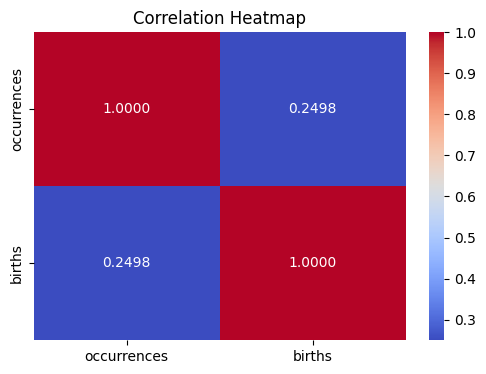

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Clean the `births` column by removing commas and converting to numeric
df['births'] = df['births'].replace({',': ''}, regex=True).astype(float)

# Check for missing values in the columns of interest
print(df[['occurrences', 'births']].isnull().sum())

# Drop rows with missing values in `occurrences` or `births`
df_cleaned = df[['occurrences', 'births']].dropna()

# Calculate the correlation
correlation = df_cleaned['occurrences'].corr(df_cleaned['births'])
print(f"Correlation between occurrences and births: {correlation:.4f}")

# Visualize the correlation with a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='births', y='occurrences', data=df_cleaned, color='blue', alpha=0.7)
plt.title('Scatter Plot of Occurrences vs Births')
plt.xlabel('Number of Births')
plt.ylabel('Number of Occurrences')
plt.grid(alpha=0.5)
plt.show()

# Visualize with a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm', fmt=".4f", cbar=True)
plt.title('Correlation Heatmap')
plt.show()



occurrences         0
dollar_exchange    80
dtype: int64
Correlation between occurrences and dollar_exchange: 0.1497


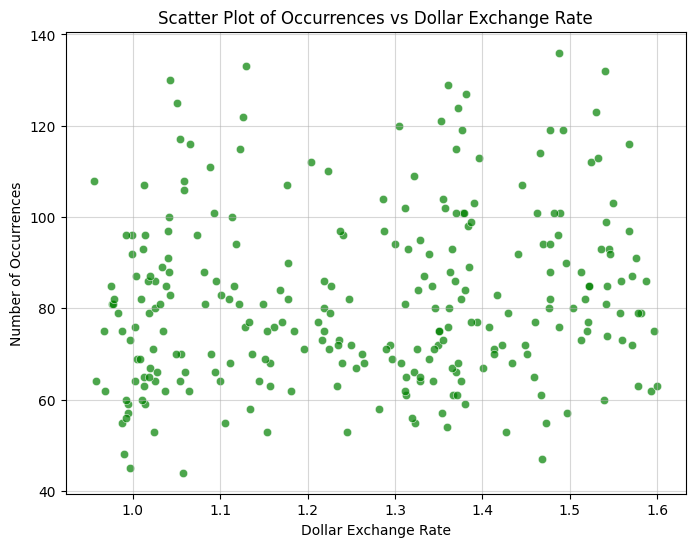

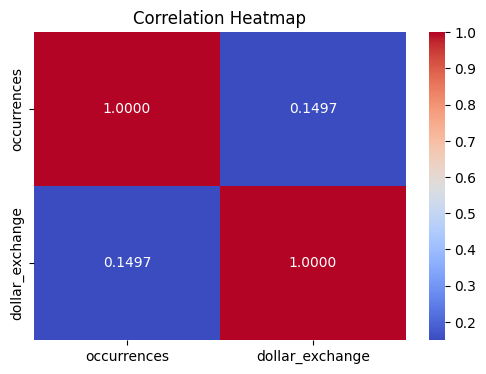

In [17]:
# Clean the `dollar_exchange` column if it contains any formatting issues (e.g., commas or invalid characters)
df['dollar_exchange'] = df['dollar_exchange'].replace({',': ''}, regex=True).astype(float)

# Check for missing values in the columns of interest
print(df[['occurrences', 'dollar_exchange']].isnull().sum())

# Drop rows with missing values in `occurrences` or `dollar_exchange`
df_cleaned = df[['occurrences', 'dollar_exchange']].dropna()

# Calculate the correlation
correlation = df_cleaned['occurrences'].corr(df_cleaned['dollar_exchange'])
print(f"Correlation between occurrences and dollar_exchange: {correlation:.4f}")

# Visualize the correlation with a scatter plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x='dollar_exchange', y='occurrences', data=df_cleaned, color='green', alpha=0.7)
plt.title('Scatter Plot of Occurrences vs Dollar Exchange Rate')
plt.xlabel('Dollar Exchange Rate')
plt.ylabel('Number of Occurrences')
plt.grid(alpha=0.5)
plt.show()

# Visualize with a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm', fmt=".4f", cbar=True)
plt.title('Correlation Heatmap')
plt.show()


occurrences            0
passenger_traffic    288
dtype: int64
Correlation between occurrences and passenger traffic: 0.7426


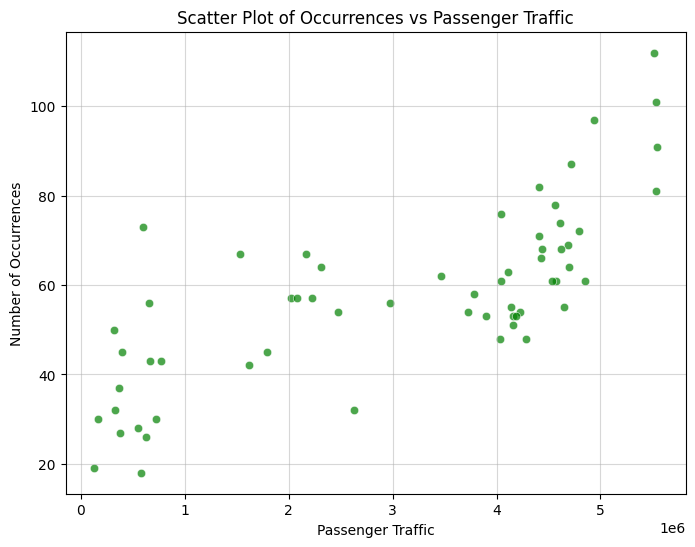

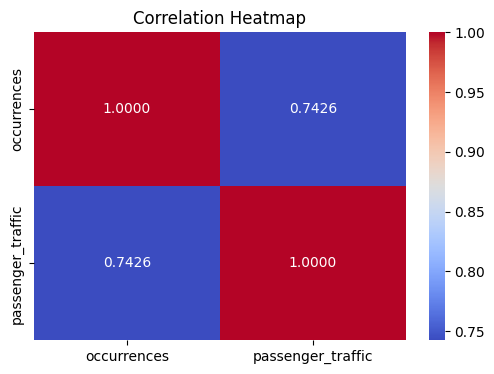

In [18]:
# Clean the `passenger_traffic` column by converting to numeric (in case of any formatting issues)
df['passenger_traffic'] = df['passenger_traffic'].replace({',': ''}, regex=True).astype(float)

# Check for missing values in the columns of interest
print(df[['occurrences', 'passenger_traffic']].isnull().sum())

# Drop rows with missing values in `occurrences` or `passenger_traffic`
df_cleaned = df[['occurrences', 'passenger_traffic']].dropna()

# Calculate the correlation
correlation = df_cleaned['occurrences'].corr(df_cleaned['passenger_traffic'])
print(f"Correlation between occurrences and passenger traffic: {correlation:.4f}")

# Visualize the correlation with a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='passenger_traffic', y='occurrences', data=df_cleaned, color='green', alpha=0.7)
plt.title('Scatter Plot of Occurrences vs Passenger Traffic')
plt.xlabel('Passenger Traffic')
plt.ylabel('Number of Occurrences')
plt.grid(alpha=0.5)
plt.show()

# Visualize with a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm', fmt=".4f", cbar=True)
plt.title('Correlation Heatmap')
plt.show()


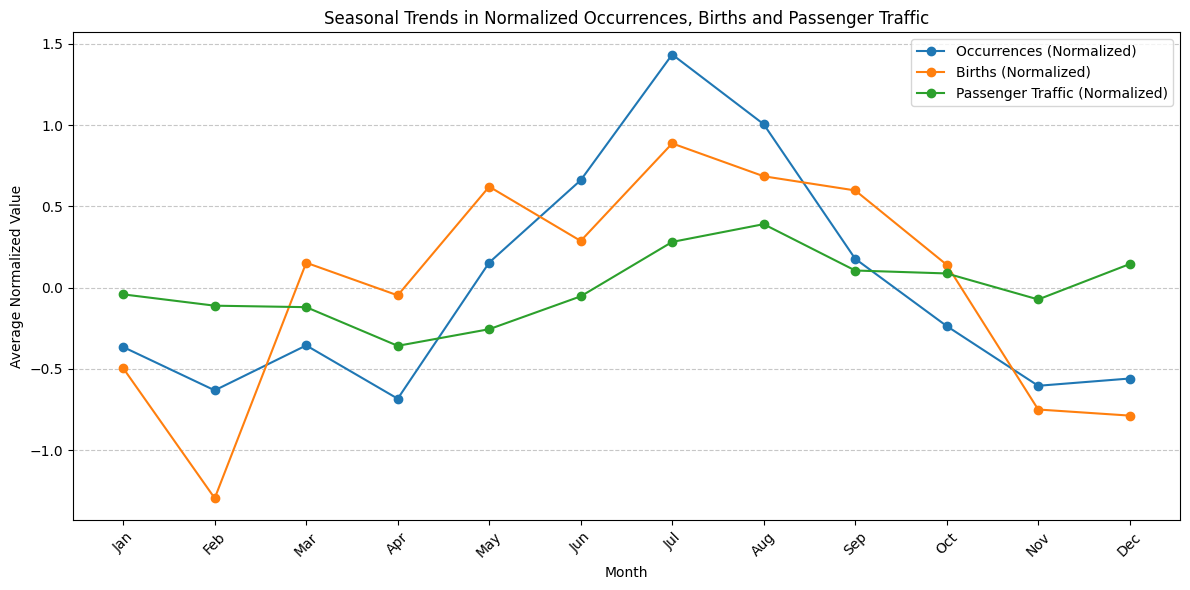

In [43]:
# Extract the month for grouping
df['Month'] = df['YearMonth'].dt.month

# Normalize all relevant columns
df['occurrences_normalized'] = (df['occurrences'] - df['occurrences'].mean()) / df['occurrences'].std()
df['births_normalized'] = (df['births'] - df['births'].mean()) / df['births'].std()
df['dollar_exchange_normalized'] = (df['dollar_exchange'] - df['dollar_exchange'].mean()) / df['dollar_exchange'].std()
df['passenger_traffic_normalized'] = (df['passenger_traffic'] - df['passenger_traffic'].mean()) / df['passenger_traffic'].std()

# Group by month to find seasonal patterns
monthly_data = df.groupby('Month')[['occurrences_normalized', 'births_normalized', 'dollar_exchange_normalized', 'passenger_traffic_normalized']].mean()

# Plot seasonal trends as a line chart
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['occurrences_normalized'], label='Occurrences (Normalized)', marker='o')
plt.plot(monthly_data.index, monthly_data['births_normalized'], label='Births (Normalized)', marker='o')
#plt.plot(monthly_data.index, monthly_data['dollar_exchange_normalized'], label='Dollar Exchange (Normalized)', marker='o')
plt.plot(monthly_data.index, monthly_data['passenger_traffic_normalized'], label='Passenger Traffic (Normalized)', marker='o')

# Customize the chart
plt.title('Seasonal Trends in Normalized Occurrences, Births and Passenger Traffic')
plt.xlabel('Month')
plt.ylabel('Average Normalized Value')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

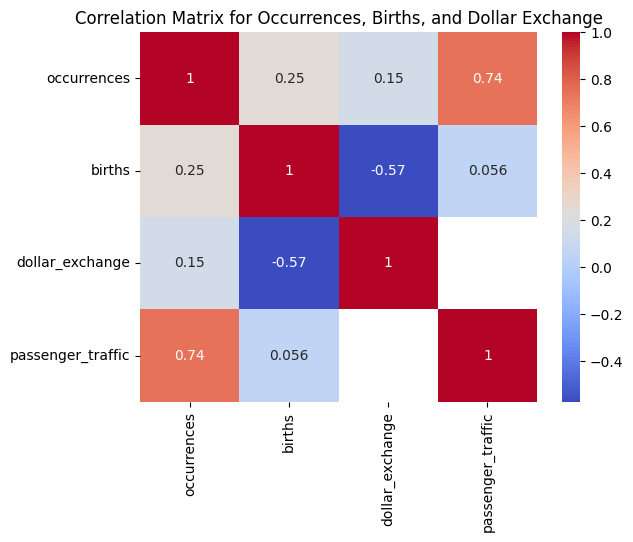

In [20]:
corr_matrix = df[['occurrences', 'births', 'dollar_exchange', 'passenger_traffic']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Occurrences, Births, and Dollar Exchange')
plt.show()

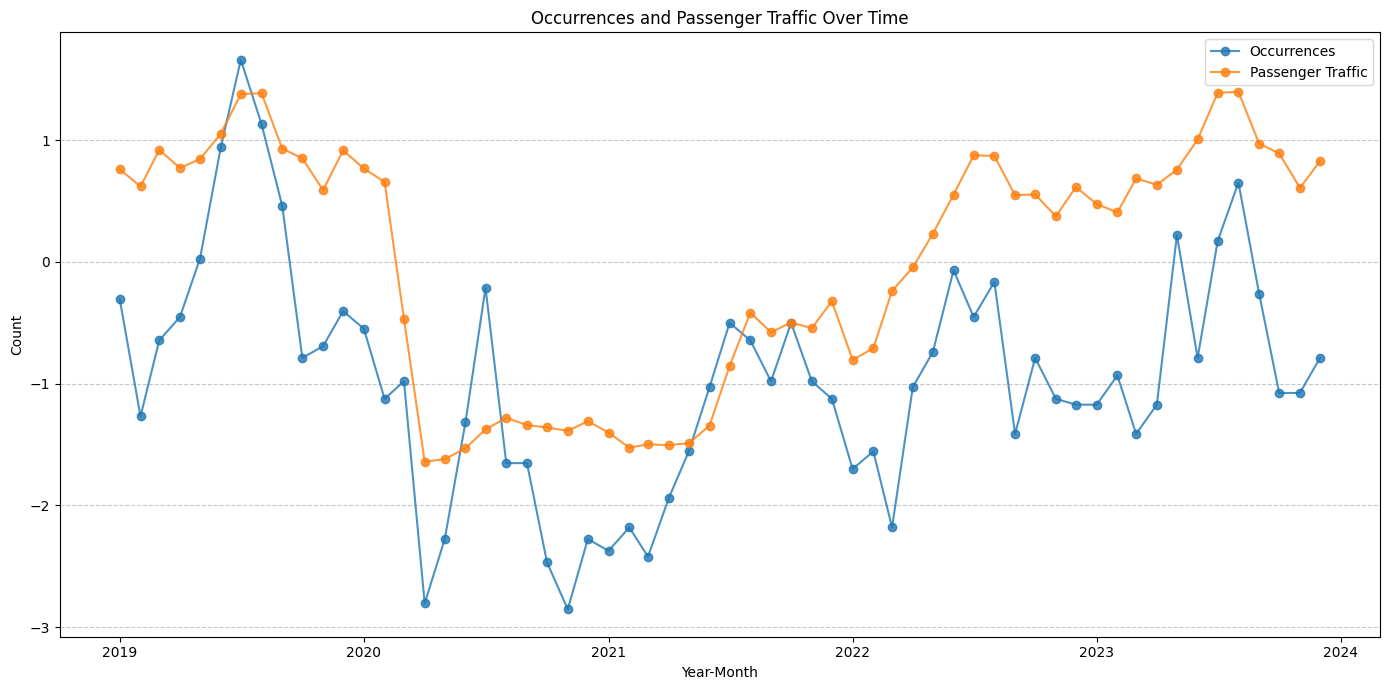

In [21]:
import matplotlib.pyplot as plt

# Filter the DataFrame to keep only rows where both 'occurrences' and 'passenger_traffic' have values
df_cleaned = df[['YearMonth', 'occurrences_normalized', 'passenger_traffic_normalized']].dropna()

# Convert 'YearMonth' from Period to Timestamp for proper plotting
df_cleaned['YearMonth'] = df_cleaned['YearMonth'].dt.to_timestamp()

# Plotting occurrences and passenger traffic over time
plt.figure(figsize=(14, 7))
plt.plot(df_cleaned['YearMonth'], df_cleaned['occurrences_normalized'], label='Occurrences', marker='o', alpha=0.8)
plt.plot(df_cleaned['YearMonth'], df_cleaned['passenger_traffic_normalized'], label='Passenger Traffic', marker='o', alpha=0.8)

# Customize the chart
plt.title('Occurrences and Passenger Traffic Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

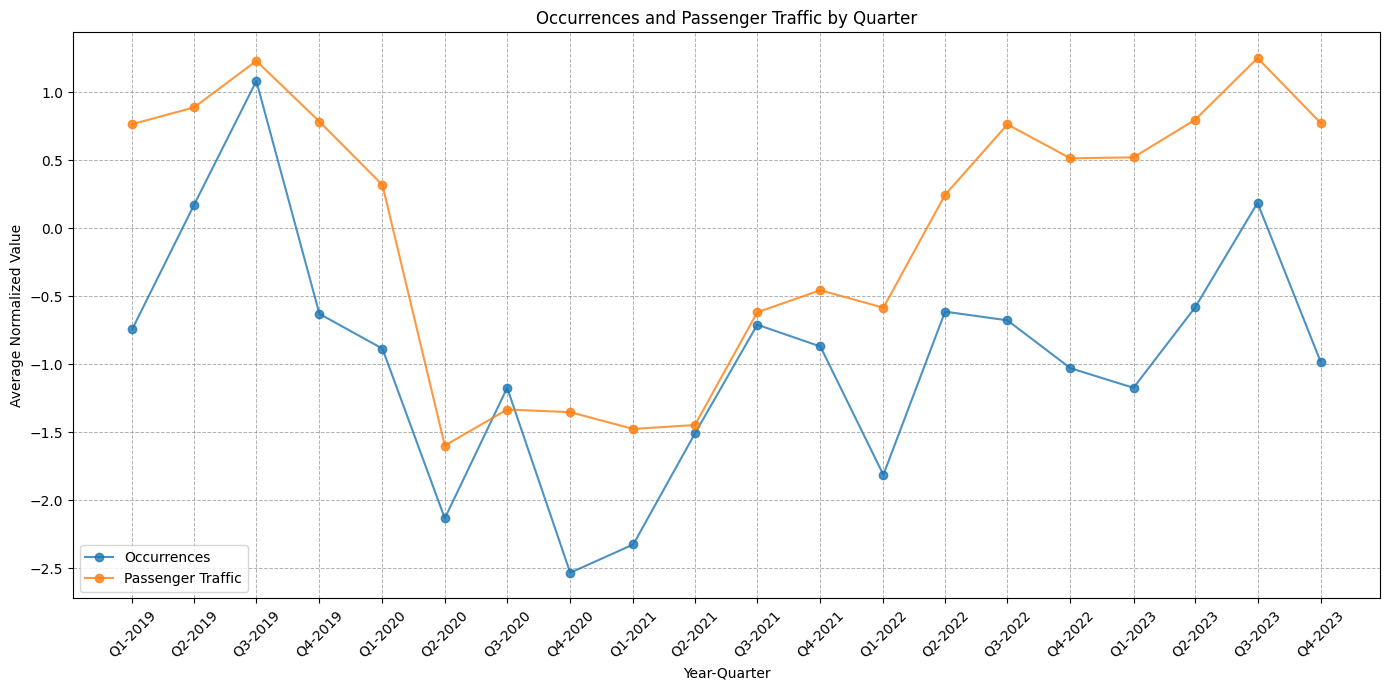

In [22]:
import matplotlib.pyplot as plt

# Filter the DataFrame to keep only rows where both 'occurrences' and 'passenger_traffic' have values
df_cleaned = df[['YearMonth', 'occurrences_normalized', 'passenger_traffic_normalized']].dropna()

# Convert 'YearMonth' from Period to Timestamp for proper plotting
df_cleaned['YearMonth'] = df_cleaned['YearMonth'].dt.to_timestamp()

# Add a 'Quarter' column to group data by year and quarter
df_cleaned['Quarter'] = df_cleaned['YearMonth'].dt.to_period('Q')

# Group by quarter and calculate the mean for each quarter
quarterly_data = df_cleaned.groupby('Quarter')[['occurrences_normalized', 'passenger_traffic_normalized']].mean()

# Reset the index to prepare for plotting
quarterly_data.reset_index(inplace=True)

# Convert 'Quarter' back to a timestamp for plotting
quarterly_data['Quarter'] = quarterly_data['Quarter'].dt.to_timestamp()

# Plotting occurrences and passenger traffic over quarters
plt.figure(figsize=(14, 7))
plt.plot(quarterly_data['Quarter'], quarterly_data['occurrences_normalized'], label='Occurrences', marker='o', alpha=0.8)
plt.plot(quarterly_data['Quarter'], quarterly_data['passenger_traffic_normalized'], label='Passenger Traffic', marker='o', alpha=0.8)

# Customize the chart
plt.title('Occurrences and Passenger Traffic by Quarter')
plt.xlabel('Year-Quarter')
plt.ylabel('Average Normalized Value')

# Customize grid
plt.grid(axis='both', linestyle='--', linewidth=0.7, alpha=0.6, color='gray')  # Enhancing grid appearance

# Set X-axis ticks to display quarters
plt.xticks(quarterly_data['Quarter'], labels=[f"Q{q.quarter}-{q.year}" for q in quarterly_data['Quarter']], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()
